In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
gdp = pd.read_csv('data/gdp_quarterly.csv')
hh_debt = pd.read_csv('data/household_debt_to_net_disposable_income_yearly.csv')
unrate = pd.read_csv('data/unemployment_rate_monthly.csv')
housing = pd.read_csv('data/housing_prices_quarterly.csv')
govt = pd.read_csv('data/govt_deficit_to_gdp_yearly.csv')
inflation = pd.read_csv('data/cpi_monthly.csv')
ppi = pd.read_csv('data/ppi_monthly.csv')

### Real quarterly GDP, percent change

In [3]:
gdp.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,OECD,QGDP,TOT,PC_CHGPP,A,1962,5.698613,NaN
1,OECD,QGDP,TOT,PC_CHGPP,A,1963,5.200709,NaN
2,OECD,QGDP,TOT,PC_CHGPP,A,1964,6.376178,NaN
3,OECD,QGDP,TOT,PC_CHGPP,A,1965,5.352665,NaN
4,OECD,QGDP,TOT,PC_CHGPP,A,1966,5.754541,NaN


In [4]:
gdp.nunique()

LOCATION         54
INDICATOR         1
SUBJECT           2
MEASURE           3
FREQUENCY         2
TIME            371
Value         23075
Flag Codes        3
dtype: int64

In [5]:
print(gdp['SUBJECT'].unique(), gdp['MEASURE'].unique(), gdp['FREQUENCY'].unique())

['TOT' 'VOLIDX'] ['PC_CHGPP' 'PC_CHGPY' 'IDX'] ['A' 'Q']


In [6]:
# percentage change from previous period
gdp = gdp[(gdp['SUBJECT'] == 'TOT') & (gdp['MEASURE'] == 'PC_CHGPP') & (gdp['FREQUENCY'] == 'Q')]

In [7]:
gdp['TIME'] = pd.to_datetime(gdp['TIME']).dt.to_period('Q').dt.end_time
print(gdp['TIME'])

445     1960-06-30 23:59:59.999999999
446     1960-09-30 23:59:59.999999999
447     1960-12-31 23:59:59.999999999
448     1961-03-31 23:59:59.999999999
449     1961-06-30 23:59:59.999999999
                     ...             
29794   2019-12-31 23:59:59.999999999
29795   2020-03-31 23:59:59.999999999
29796   2020-06-30 23:59:59.999999999
29797   2020-09-30 23:59:59.999999999
29798   2020-12-31 23:59:59.999999999
Name: TIME, Length: 9418, dtype: datetime64[ns]


In [8]:
gdp_new = gdp.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
gdp_new.columns = ['Location', 'Time', 'GDP']
gdp_new.head()

,Location,Time,GDP
445,KOR,1960-06-30 23:59:59.999999999,4.496005
446,KOR,1960-09-30 23:59:59.999999999,-1.111563
447,KOR,1960-12-31 23:59:59.999999999,0.596299
448,KOR,1961-03-31 23:59:59.999999999,3.200927
449,KOR,1961-06-30 23:59:59.999999999,4.316423


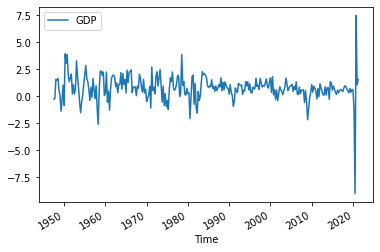

In [9]:
gdp_new[gdp_new['Location'] == 'USA'].plot(x='Time', y='GDP')

### Household debt, % of net disposable income

In [10]:
hh_debt.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HHDEBT,TOT,PC_NDI,A,1995,94.86145,NaN
1,AUS,HHDEBT,TOT,PC_NDI,A,1996,98.62147,NaN
2,AUS,HHDEBT,TOT,PC_NDI,A,1997,106.62240,NaN
3,AUS,HHDEBT,TOT,PC_NDI,A,1998,114.09520,NaN
4,AUS,HHDEBT,TOT,PC_NDI,A,1999,120.42900,NaN


In [11]:
hh_debt.nunique()

LOCATION       36
INDICATOR       1
SUBJECT         1
MEASURE         1
FREQUENCY       1
TIME           26
Value         797
Flag Codes      0
dtype: int64

In [12]:
hh_debt['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC',
       'HUN', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX', 'NLD', 'NOR',
       'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE', 'GBR', 'USA', 'CHL',
       'EST', 'SVN', 'CAN', 'LVA', 'BRA', 'LTU', 'RUS', 'NZL', 'COL'],
      dtype=object)

In [13]:
hh_debt['TIME'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

In [14]:
hh_debt['TIME'] = pd.to_datetime(hh_debt['TIME'].astype(str), format='%Y').dt.to_period('A').dt.end_time
hh_debt['TIME']

0     1995-12-31 23:59:59.999999999
1     1996-12-31 23:59:59.999999999
2     1997-12-31 23:59:59.999999999
3     1998-12-31 23:59:59.999999999
4     1999-12-31 23:59:59.999999999
                   ...             
792   2015-12-31 23:59:59.999999999
793   2016-12-31 23:59:59.999999999
794   2017-12-31 23:59:59.999999999
795   2018-12-31 23:59:59.999999999
796   2019-12-31 23:59:59.999999999
Name: TIME, Length: 797, dtype: datetime64[ns]

In [15]:
hh_debt_new = hh_debt.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
hh_debt_new.columns = ['Location', 'Time', 'HH Debt']
hh_debt_new.head()

,Location,Time,HH Debt
0,AUS,1995-12-31 23:59:59.999999999,94.86145
1,AUS,1996-12-31 23:59:59.999999999,98.62147
2,AUS,1997-12-31 23:59:59.999999999,106.62240
3,AUS,1998-12-31 23:59:59.999999999,114.09520
4,AUS,1999-12-31 23:59:59.999999999,120.42900


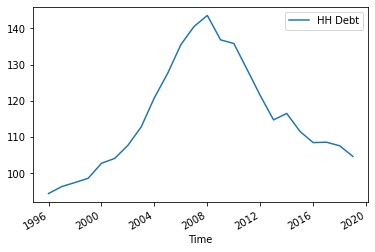

In [16]:
hh_debt_new[hh_debt_new['Location'] == 'USA'].plot(x='Time', y='HH Debt')

Compute percentage change for each location.

In [17]:
hh_debt_new['HH Debt pct change'] = hh_debt_new.sort_values('Time').groupby('Location')['HH Debt'].pct_change().mul(100)
hh_debt_new.head(30)

,Location,Time,HH Debt,HH Debt pct change
0,AUS,1995-12-31 23:59:59.999999999,94.86145,NaN
1,AUS,1996-12-31 23:59:59.999999999,98.62147,3.963697
2,AUS,1997-12-31 23:59:59.999999999,106.62240,8.112767
3,AUS,1998-12-31 23:59:59.999999999,114.09520,7.008659
4,AUS,1999-12-31 23:59:59.999999999,120.42900,5.551329
5,AUS,2000-12-31 23:59:59.999999999,125.20920,3.969310
6,AUS,2001-12-31 23:59:59.999999999,130.52230,4.243378
7,AUS,2002-12-31 23:59:59.999999999,150.04060,14.953996
8,AUS,2003-12-31 23:59:59.999999999,161.50960,7.643931
9,AUS,2004-12-31 23:59:59.999999999,171.80570,6.374915


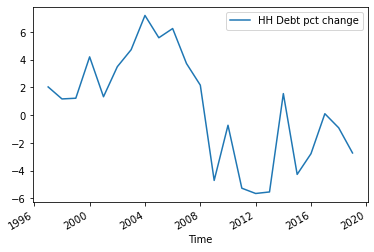

In [18]:
hh_debt_new[hh_debt_new['Location'] == 'USA'].plot(x='Time', y='HH Debt pct change')

### Unemployment rate, % of labour force

In [19]:
unrate.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [20]:
unrate.nunique()

LOCATION         42
INDICATOR         1
SUBJECT           3
MEASURE           1
FREQUENCY         3
TIME           1162
Value         13485
Flag Codes        3
dtype: int64

In [21]:
print(unrate['SUBJECT'].unique(), unrate['FREQUENCY'].unique(), unrate['Flag Codes'].unique())

['TOT' 'MEN' 'WOMEN'] ['A' 'Q' 'M'] [nan 'B' 'E' 'P']


In [22]:
unrate = unrate[(unrate['SUBJECT'] == 'TOT') & (unrate['FREQUENCY'] == 'M')]

In [23]:
unrate['TIME'] = pd.to_datetime(unrate['TIME'].astype(str), format='%Y-%m').dt.to_period('M').dt.end_time

In [24]:
unrate_new = unrate.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
unrate_new.columns = ['Location', 'Time', 'Unemployment']
unrate_new.head()

,Location,Time,Unemployment
5989,AUS,1978-02-28 23:59:59.999999999,6.644867
5990,AUS,1978-03-31 23:59:59.999999999,6.302329
5991,AUS,1978-04-30 23:59:59.999999999,6.267148
5992,AUS,1978-05-31 23:59:59.999999999,6.209167
5993,AUS,1978-06-30 23:59:59.999999999,6.303327


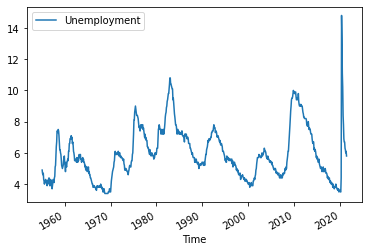

In [25]:
unrate_new[unrate_new['Location'] == 'USA'].plot(x='Time', y='Unemployment')

Compute percentage change of unemployment rate.

In [26]:
unrate_new['Unemployment pct change'] = unrate_new.sort_values('Time').groupby('Location')['Unemployment'].pct_change().mul(100)
unrate_new.head()

,Location,Time,Unemployment,Unemployment pct change
5989,AUS,1978-02-28 23:59:59.999999999,6.644867,NaN
5990,AUS,1978-03-31 23:59:59.999999999,6.302329,-5.154926
5991,AUS,1978-04-30 23:59:59.999999999,6.267148,-0.558222
5992,AUS,1978-05-31 23:59:59.999999999,6.209167,-0.925158
5993,AUS,1978-06-30 23:59:59.999999999,6.303327,1.516468


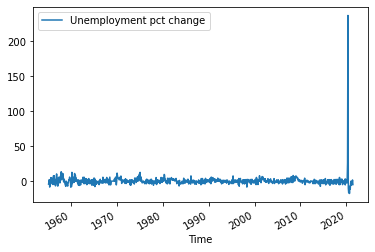

In [27]:
unrate_new[unrate_new['Location'] == 'USA'].plot(x='Time', y='Unemployment pct change')

### Housing prices

In [28]:
housing.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HOUSECOST,NOMINAL,IDX2015,A,1970,2.552380,NaN
1,AUS,HOUSECOST,NOMINAL,IDX2015,A,1971,2.851352,NaN
2,AUS,HOUSECOST,NOMINAL,IDX2015,A,1972,3.183667,NaN
3,AUS,HOUSECOST,NOMINAL,IDX2015,A,1973,3.837183,NaN
4,AUS,HOUSECOST,NOMINAL,IDX2015,A,1974,4.690199,NaN


In [29]:
housing.nunique()

LOCATION         50
INDICATOR         1
SUBJECT           5
MEASURE           1
FREQUENCY         2
TIME            327
Value         38323
Flag Codes        0
dtype: int64

In [30]:
print(housing['SUBJECT'].unique(), housing['FREQUENCY'].unique())

['NOMINAL' 'PRICEINCOME' 'PRICERENT' 'REAL' 'RENT'] ['A' 'Q']


In [31]:
housing_income = housing[(housing['SUBJECT'] == 'PRICEINCOME') & (housing['FREQUENCY'] == 'Q')]
housing_income['TIME'] = pd.to_datetime(housing_income['TIME']).dt.to_period('Q').dt.end_time
housing_income_new = housing_income.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
housing_income_new.columns = ['Location', 'Time', 'House price to income']

In [32]:
housing_rent = housing[(housing['SUBJECT'] == 'PRICERENT') & (housing['FREQUENCY'] == 'Q')]
housing_rent['TIME'] = pd.to_datetime(housing_rent['TIME']).dt.to_period('Q').dt.end_time
housing_rent_new = housing_rent.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
housing_rent_new.columns = ['Location', 'Time', 'House price to rent']

In [33]:
housing_new = housing_income_new.merge(housing_rent_new, on=['Location', 'Time'])
housing_new

,Location,Time,House price to income,House price to rent
0,AUS,1972-09-30 23:59:59.999999999,59.671086,36.266491
1,AUS,1972-12-31 23:59:59.999999999,59.944554,37.743660
2,AUS,1973-03-31 23:59:59.999999999,59.789834,37.920062
3,AUS,1973-06-30 23:59:59.999999999,61.400542,39.760156
4,AUS,1973-09-30 23:59:59.999999999,62.199570,42.423984
...,...,...,...,...
5062,COL,2018-12-31 23:59:59.999999999,104.357125,112.168525
5063,COL,2019-03-31 23:59:59.999999999,104.715704,113.743068
5064,COL,2019-06-30 23:59:59.999999999,104.180660,113.613583
5065,COL,2019-09-30 23:59:59.999999999,106.518755,116.100132


In [34]:
housing_new['Rent to income'] = housing_new['House price to income'] / housing_new['House price to rent']
housing_new.head()

,Location,Time,House price to income,House price to rent,Rent to income
0,AUS,1972-09-30 23:59:59.999999999,59.671086,36.266491,1.645350
1,AUS,1972-12-31 23:59:59.999999999,59.944554,37.743660,1.588202
2,AUS,1973-03-31 23:59:59.999999999,59.789834,37.920062,1.576734
3,AUS,1973-06-30 23:59:59.999999999,61.400542,39.760156,1.544273
4,AUS,1973-09-30 23:59:59.999999999,62.199570,42.423984,1.466142


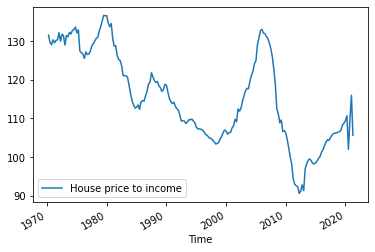

In [35]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House price to income')

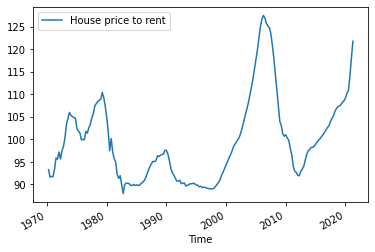

In [36]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House price to rent')

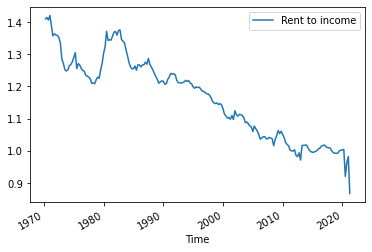

In [37]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='Rent to income')

Compute percentage change of each column.

In [38]:
housing_new['House price to income pct change'] = housing_new.sort_values('Time').groupby('Location')['House price to income'].pct_change().mul(100)
housing_new['House price to rent pct change'] = housing_new.sort_values('Time').groupby('Location')['House price to rent'].pct_change().mul(100)
housing_new['Rent to income pct change'] = housing_new.sort_values('Time').groupby('Location')['Rent to income'].pct_change().mul(100)

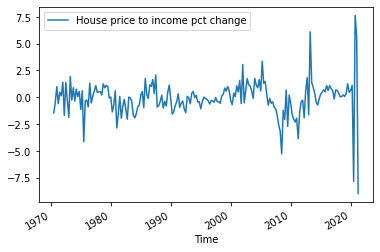

In [39]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House price to income pct change')

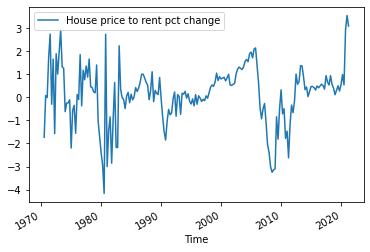

In [40]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House price to rent pct change')

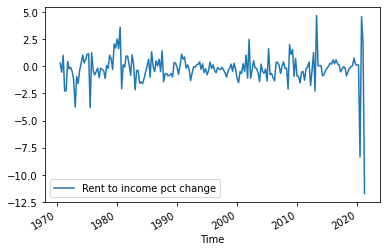

In [41]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='Rent to income pct change')

### Govt deficit, % of GDP

In [42]:
govt.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,GGNLEND,TOT,PC_GDP,A,1970,-1.530486,NaN
1,AUS,GGNLEND,TOT,PC_GDP,A,1971,-1.497168,NaN
2,AUS,GGNLEND,TOT,PC_GDP,A,1972,-1.963938,NaN
3,AUS,GGNLEND,TOT,PC_GDP,A,1973,-0.827913,NaN
4,AUS,GGNLEND,TOT,PC_GDP,A,1974,-3.450020,NaN


In [43]:
govt.nunique()

LOCATION        45
INDICATOR        1
SUBJECT          1
MEASURE          1
FREQUENCY        1
TIME            51
Value         1197
Flag Codes       2
dtype: int64

In [44]:
govt['TIME'] = pd.to_datetime(govt['TIME'].astype(str), format='%Y').dt.to_period('A').dt.end_time

In [45]:
govt_new = govt.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
govt_new.columns = ['Location', 'Time', 'Govt deficit to GDP']
govt_new.head()

,Location,Time,Govt deficit to GDP
0,AUS,1970-12-31 23:59:59.999999999,-1.530486
1,AUS,1971-12-31 23:59:59.999999999,-1.497168
2,AUS,1972-12-31 23:59:59.999999999,-1.963938
3,AUS,1973-12-31 23:59:59.999999999,-0.827913
4,AUS,1974-12-31 23:59:59.999999999,-3.450020


Upsample data from annual to monthly.

In [48]:
govt_new['new value'] = govt_new['Govt deficit to GDP'].asfreq('M').interpolate()

In [49]:
govt_new.head()

,Location,Time,Govt deficit to GDP,new value
0,AUS,1970-12-31 23:59:59.999999999,-1.530486,NaN
1,AUS,1971-12-31 23:59:59.999999999,-1.497168,NaN
2,AUS,1972-12-31 23:59:59.999999999,-1.963938,NaN
3,AUS,1973-12-31 23:59:59.999999999,-0.827913,NaN
4,AUS,1974-12-31 23:59:59.999999999,-3.450020,NaN


In [51]:
govt_new['Govt deficit to GDP interp'] = govt_new.sort_values('Time').groupby('Location')['Govt deficit to GDP'].apply(lambda x: x.interpolate())

In [52]:
govt_new.head()

,Location,Time,Govt deficit to GDP,Govt deficit to GDP interp
0,AUS,1970-12-31 23:59:59.999999999,-1.530486,-1.530486
1,AUS,1971-12-31 23:59:59.999999999,-1.497168,-1.497168
2,AUS,1972-12-31 23:59:59.999999999,-1.963938,-1.963938
3,AUS,1973-12-31 23:59:59.999999999,-0.827913,-0.827913
4,AUS,1974-12-31 23:59:59.999999999,-3.450020,-3.450020


In [ ]:
govt_new['Govt Deficit to GDP interp'] = govt_new.sort_values('Time').groupby('Location')['Govt Deficit to GDP'].resample('M').mean()

In [ ]:
govt_new[govt_new['Location'] == 'USA'].plot(x='Time', y='Govt Deficit to GDP')

### Inflation (CPI), annual growth rate (%)

In [ ]:
inflation.head()

In [ ]:
inflation.nunique()

In [ ]:
print(inflation['SUBJECT'].unique(), inflation['MEASURE'].unique(), inflation['FREQUENCY'].unique())

In [ ]:
inflation = inflation[(inflation['SUBJECT'] == 'TOT') & (inflation['MEASURE'] == 'AGRWTH') & (inflation['FREQUENCY'] == 'M')]
inflation.head()

In [ ]:
inflation['TIME'] = pd.to_datetime(inflation['TIME']).dt.to_period('M').dt.end_time
inflation['TIME']

In [ ]:
inflation_new = inflation.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
inflation_new.columns = ['Location', 'Time', 'Inflation annual growth rate']
inflation_new.head()

In [ ]:
inflation_new[inflation_new['Location'] == 'USA'].plot(x='Time', y='Inflation annual growth rate')

### Producer price indice (PPI), domestic market manufacturing

In [ ]:
ppi.head()

In [ ]:
ppi.nunique()

In [ ]:
print(ppi['SUBJECT'].unique(), ppi['MEASURE'].unique(), ppi['FREQUENCY'].unique())

In [ ]:
ppi['LOCATION'][ppi['SUBJECT'] == 'TOT_MKT'].unique()

In [ ]:
ppi = ppi[(ppi['SUBJECT'] == 'TOT_MKT') & (ppi['MEASURE'] == 'AGRWTH') & (ppi['FREQUENCY'] == 'M')]
ppi.head()

In [ ]:
ppi['TIME'] = pd.to_datetime(ppi['TIME']).dt.to_period('M').dt.end_time
ppi.head()

In [ ]:
ppi_new = ppi.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
ppi_new.columns = ['Location', 'Time', 'PPI annual growth rate']
ppi_new.head()

In [ ]:
ppi_new[ppi_new['Location'] == 'USA'].plot(x='Time', y='PPI annual growth rate')

### Create new dataframe

Merge all dataframes into a final dataframe. Keep in mind that GDP is our target column, and the values exist in the feature columns but not in our target column will be useless. Hence, we use merge and left join them based on our target column.

In [ ]:
df = gdp_new.merge(inflation_new, on=['Location', 'Time'], how='left')
df = df.merge(ppi_new, on=['Location', 'Time'], how='left')
df = df.merge(unrate_new, on=['Location', 'Time'], how='left')
df = df.merge(housing_new, on=['Location', 'Time'], how='left')
df = df.merge(hh_debt_new, on=['Location', 'Time'], how='left')
df = df.merge(govt_new, on=['Location', 'Time'], how='left')
df.sample(5)

In [ ]:
df.to_csv('data/features_summary.csv')